# Assignment 4: Variational Autoencoders

## Submitted By: Aarathi Vijayachandran (244267)

### Assignment question is available here: https://ovgu-ailab.github.io/lgm2024/assignment4.html

## Implementing a VAE -  Using SVHN dataset

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, losses, models
import tensorflow_datasets as tfds
import numpy as np

# Load the SVHN dataset
(ds_train, ds_test), ds_info = tfds.load(
    'svhn_cropped',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

latent_dim = 2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(original_dim, activation='sigmoid')
        self.reshape = layers.Reshape((32, 32, 3))

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.reshape(x)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

# VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = self.sampling((mean, log_var))
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Loss function
def compute_loss(model, x):
    reconstructed, mean, log_var = model(x)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x, reconstructed)
    )
    kl_loss = -0.5 * tf.reduce_mean(
        1 + log_var - tf.square(mean) - tf.exp(log_var)
    )
    return reconstruction_loss + kl_loss

# Model instantiation
original_dim = 32 * 32 * 3
encoder = Encoder(latent_dim)
decoder = Decoder(original_dim)
vae = VAE(encoder, decoder)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training step
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        loss = compute_loss(vae, x)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Training loop
epochs = 30
for epoch in range(epochs):
    for train_x, _ in ds_train:
        loss = train_step(train_x)
    print(f'Epoch: {epoch + 1}, Loss: {loss.numpy()}')

# Evaluation on test set
for test_x, _ in ds_test:
    loss = compute_loss(vae, test_x)
print(f'Test Loss: {loss.numpy()}')


Epoch: 1, Loss: 0.6958849430084229
Epoch: 2, Loss: 0.6891547441482544
Epoch: 3, Loss: 0.6902450323104858
Epoch: 4, Loss: 0.6882234811782837
Epoch: 5, Loss: 0.6890743374824524
Epoch: 6, Loss: 0.6882025599479675
Epoch: 7, Loss: 0.6882573366165161
Epoch: 8, Loss: 0.6881459951400757
Epoch: 9, Loss: 0.6880118250846863
Epoch: 10, Loss: 0.6878912448883057
Epoch: 11, Loss: 0.6880025267601013
Epoch: 12, Loss: 0.6881725788116455
Epoch: 13, Loss: 0.6879444718360901
Epoch: 14, Loss: 0.687958300113678
Epoch: 15, Loss: 0.6879686713218689
Epoch: 16, Loss: 0.6879213452339172
Epoch: 17, Loss: 0.6878798007965088
Epoch: 18, Loss: 0.6878467202186584
Epoch: 19, Loss: 0.6878854036331177
Epoch: 20, Loss: 0.6878597736358643
Epoch: 21, Loss: 0.6878658533096313
Epoch: 22, Loss: 0.6878657341003418
Epoch: 23, Loss: 0.6878640055656433
Epoch: 24, Loss: 0.6878759264945984
Epoch: 25, Loss: 0.6878001689910889
Epoch: 26, Loss: 0.6878584027290344
Epoch: 27, Loss: 0.6878628134727478
Epoch: 28, Loss: 0.6878669261932373
Ep

## Experiments - Beta-VAE on SVHN dataset

Training Beta-VAE with beta=0.1
Epoch: 1, Loss: 28.23026466369629
Epoch: 2, Loss: 28.231401443481445
Epoch: 3, Loss: 28.209016799926758
Epoch: 4, Loss: 28.222614288330078
Epoch: 5, Loss: 28.2132625579834
Epoch: 6, Loss: 28.212661743164062
Epoch: 7, Loss: 28.178831100463867
Epoch: 8, Loss: 28.214693069458008
Epoch: 9, Loss: 28.228532791137695
Epoch: 10, Loss: 28.200965881347656
Epoch: 11, Loss: 28.20337677001953
Epoch: 12, Loss: 28.204662322998047
Epoch: 13, Loss: 28.204511642456055
Epoch: 14, Loss: 28.206802368164062
Epoch: 15, Loss: 28.210369110107422
Epoch: 16, Loss: 28.202896118164062
Epoch: 17, Loss: 28.202245712280273
Epoch: 18, Loss: 28.202287673950195
Epoch: 19, Loss: 28.203289031982422
Epoch: 20, Loss: 28.203014373779297
Epoch: 21, Loss: 28.199798583984375
Epoch: 22, Loss: 28.202404022216797
Epoch: 23, Loss: 28.202552795410156
Epoch: 24, Loss: 28.202587127685547
Epoch: 25, Loss: 28.20235824584961
Epoch: 26, Loss: 28.202678680419922
Epoch: 27, Loss: 28.20261001586914
Epoch: 28, 

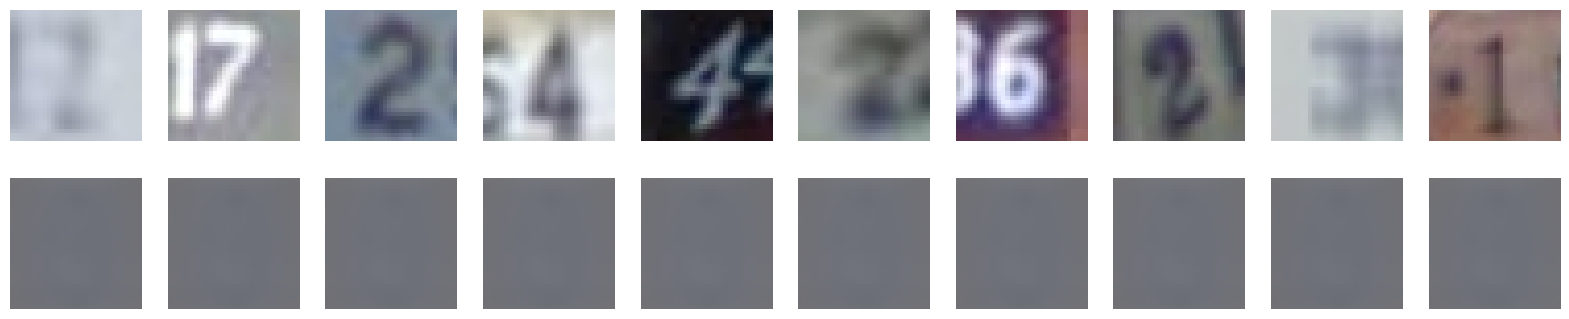

Reconstructions for beta=0.5


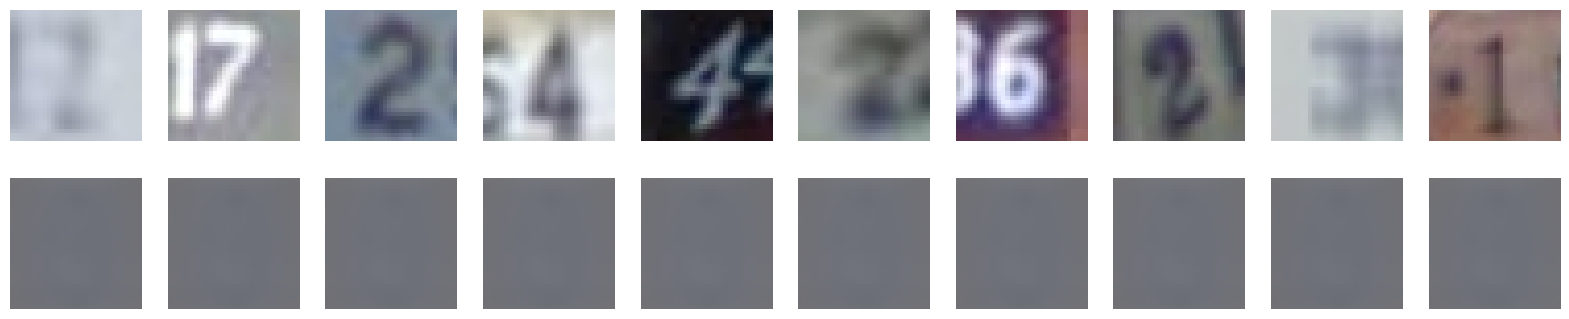

Reconstructions for beta=1


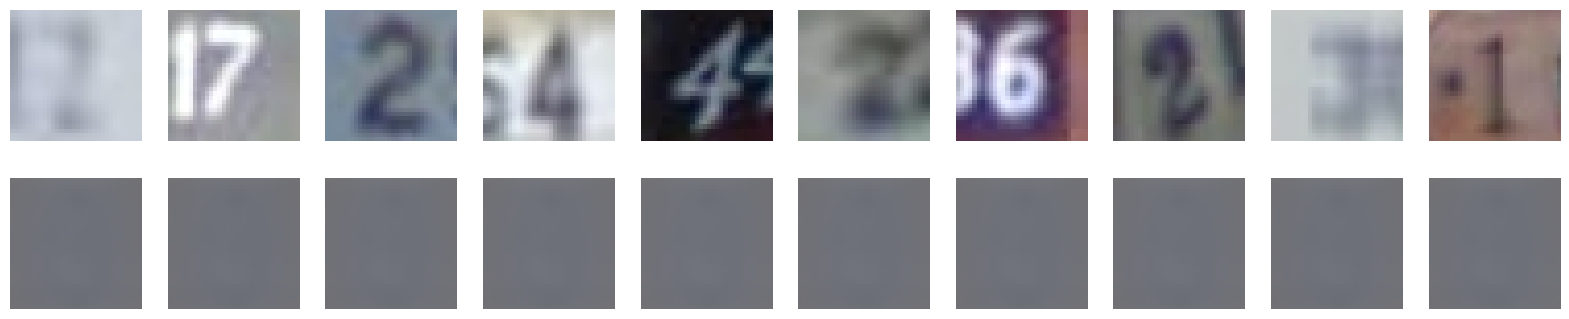

Reconstructions for beta=2


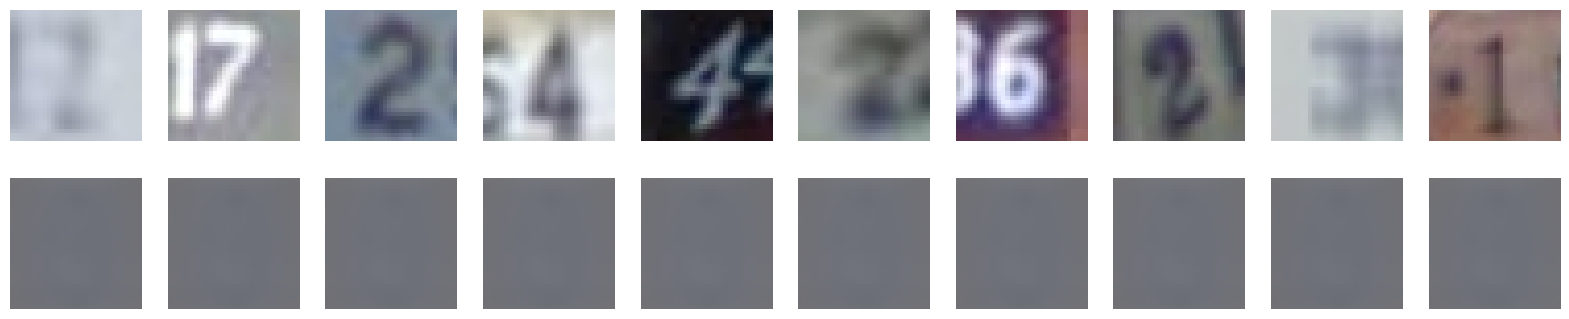

Reconstructions for beta=5


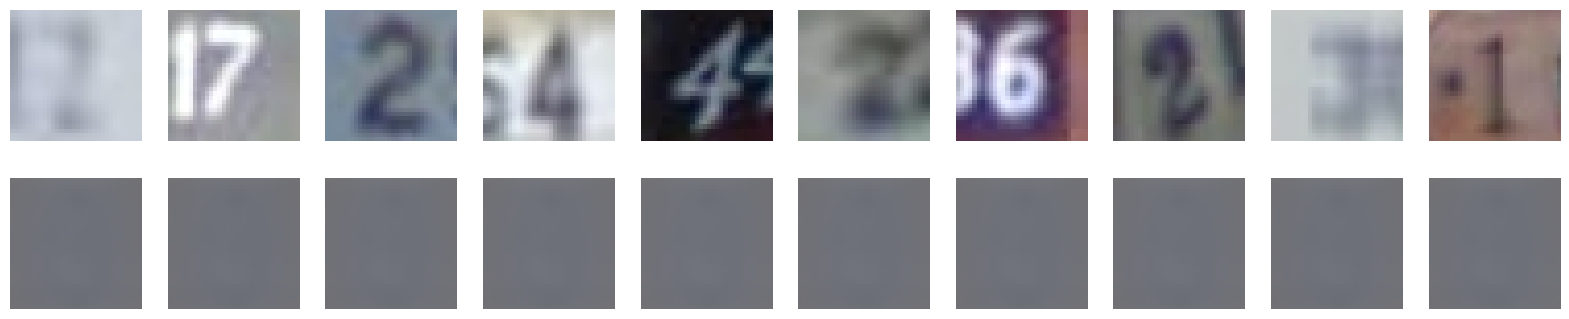

Reconstructions for beta=10


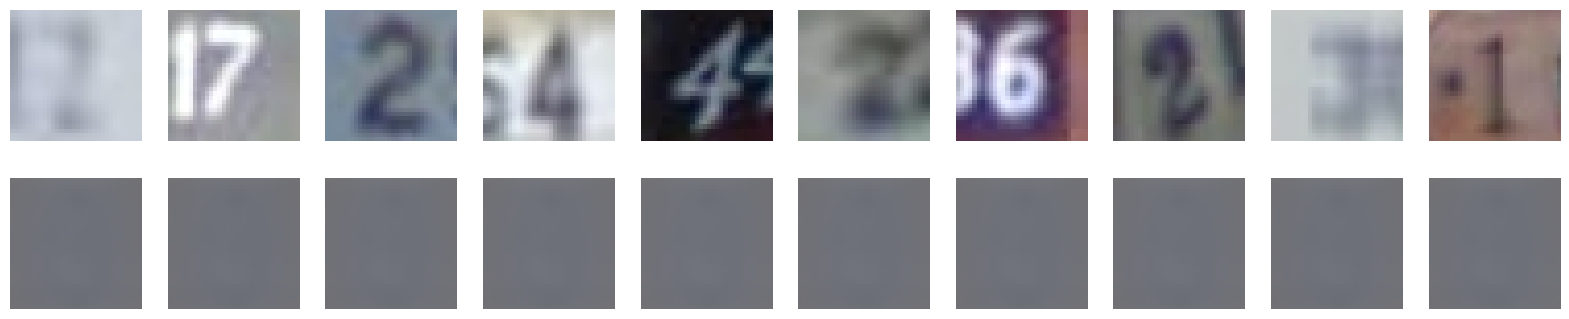

Generated samples for beta=0.1


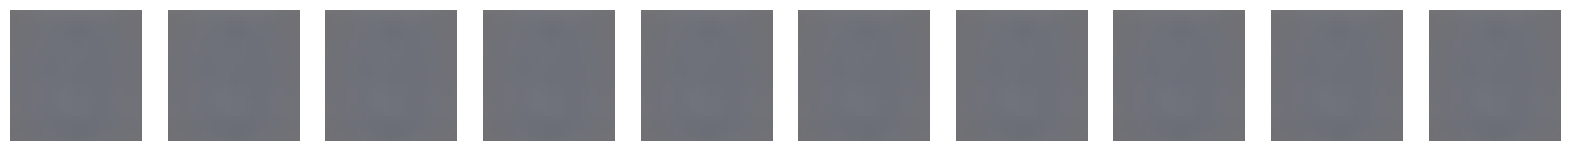

Generated samples for beta=0.5


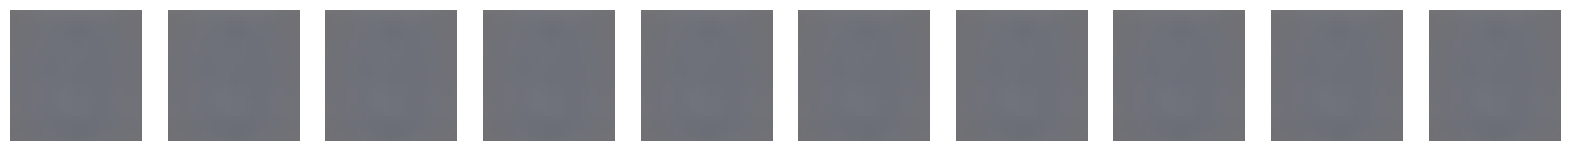

Generated samples for beta=1


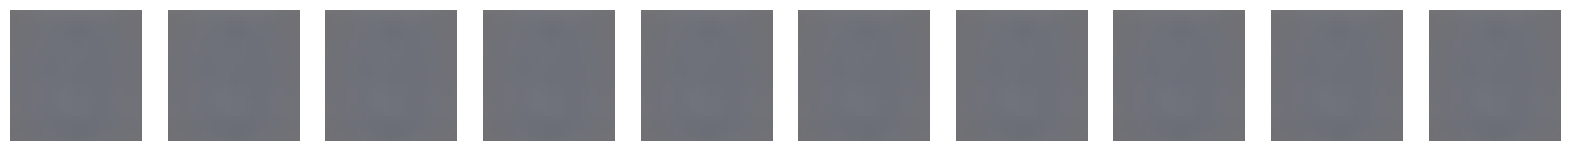

Generated samples for beta=2


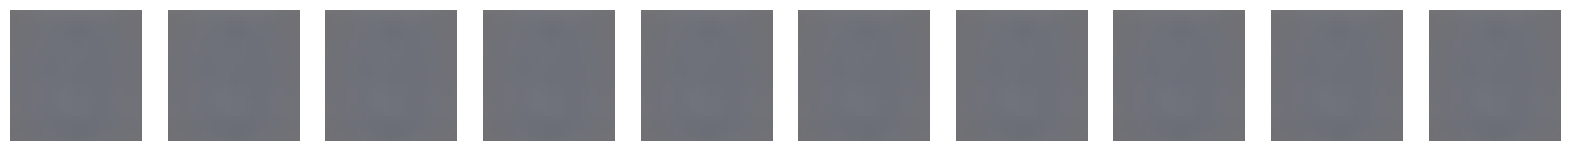

Generated samples for beta=5


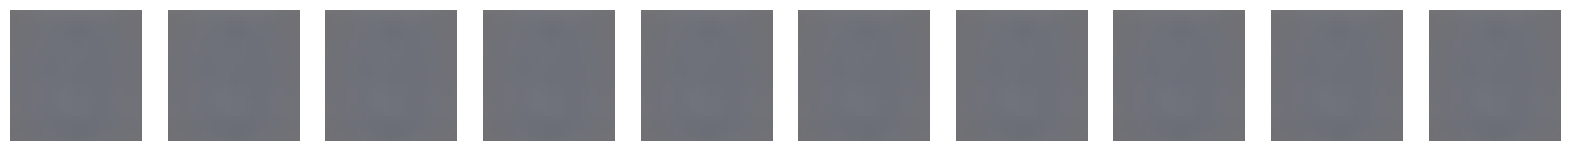

Generated samples for beta=10


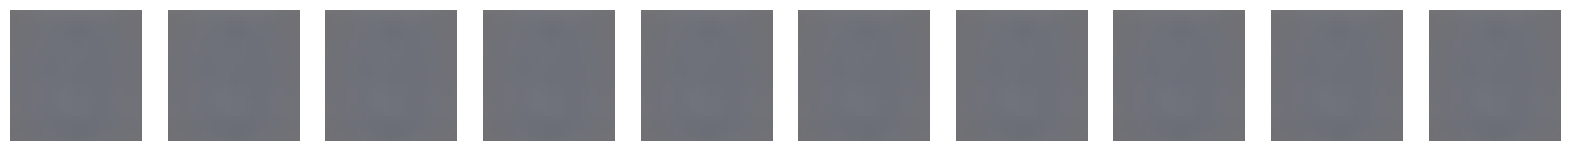

Reconstruction quality for different beta values:
beta=0.1, reconstruction quality=88.00599670410156
beta=0.5, reconstruction quality=88.0060043334961
beta=1, reconstruction quality=88.0060043334961
beta=2, reconstruction quality=88.0060043334961
beta=5, reconstruction quality=88.00601959228516
beta=10, reconstruction quality=88.00605773925781
Latent space interpolation for beta=0.1


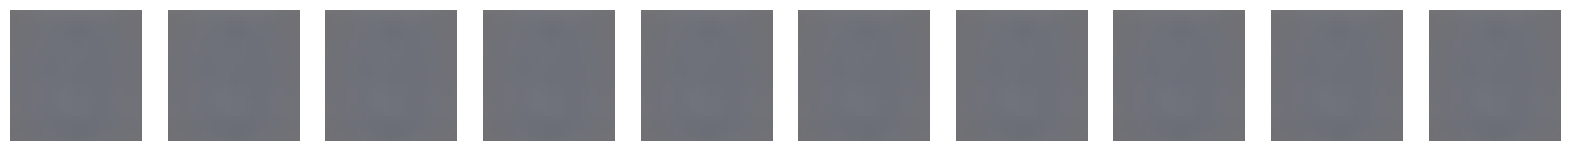

Latent space interpolation for beta=0.5


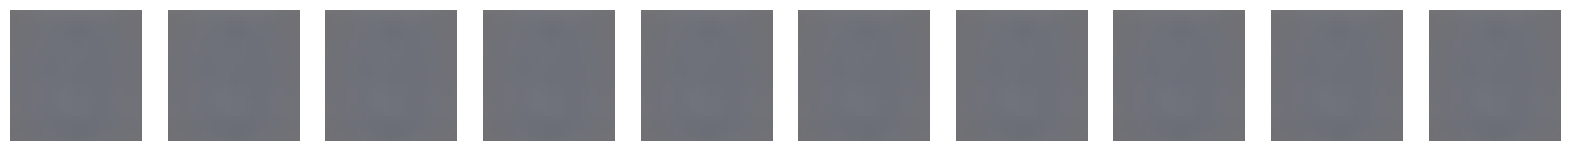

Latent space interpolation for beta=1


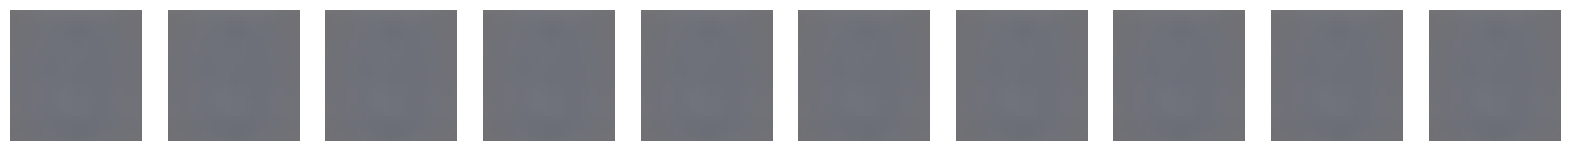

Latent space interpolation for beta=2


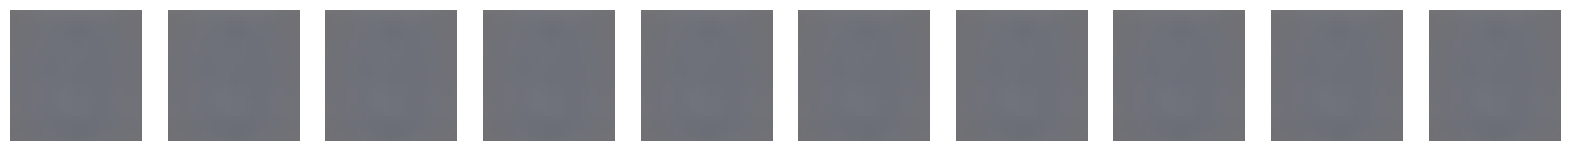

Latent space interpolation for beta=5


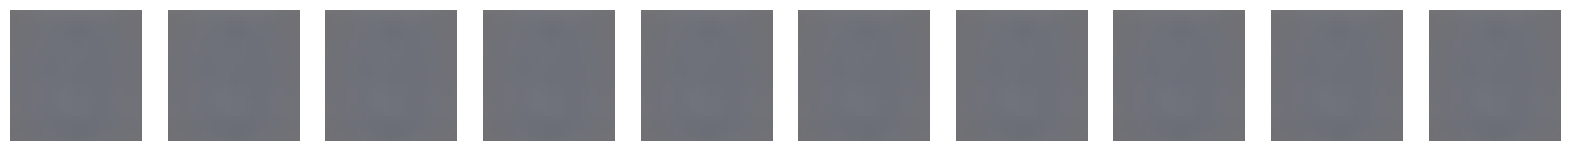

Latent space interpolation for beta=10


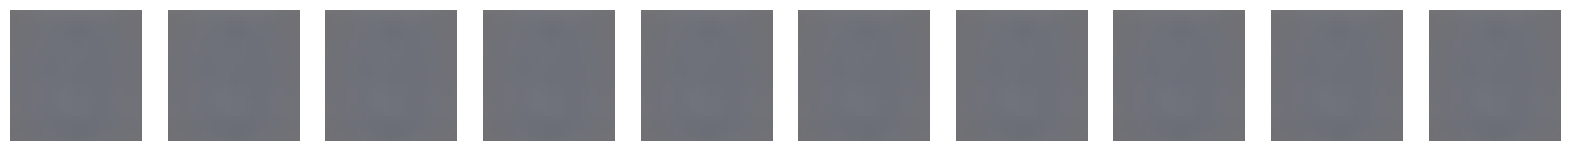

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, losses, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Load the SVHN dataset
(ds_train, ds_test), ds_info = tfds.load(
    'svhn_cropped',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

latent_dim = 2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(original_dim, activation='sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

# Beta-VAE model
class BetaVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, original_dim, beta=1):
        super(BetaVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.original_dim = original_dim
        self.beta = beta

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = self.sampling((mean, log_var))
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Loss function
def compute_loss(model, x):
    reconstructed, mean, log_var = model(x)
    reconstruction_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(x, reconstructed)
    )
    kl_loss = -0.5 * tf.reduce_sum(
        1 + log_var - tf.square(mean) - tf.exp(log_var)
    )
    return reconstruction_loss + model.beta * kl_loss

# Model instantiation
original_dim = 32 * 32 * 3
encoder = Encoder(latent_dim)
decoder = Decoder(original_dim)

def train_vae(beta, epochs=30):
    vae = BetaVAE(encoder, decoder, original_dim, beta)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    @tf.function
    def train_step(x):
        with tf.GradientTape() as tape:
            loss = compute_loss(vae, x)
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
        return loss

    for epoch in range(epochs):
        for train_x, _ in ds_train:
            train_x = tf.reshape(train_x, [-1, original_dim])
            loss = train_step(train_x)
        print(f'Epoch: {epoch + 1}, Loss: {loss.numpy()}')

    return vae

# Train models with different beta values
betas = [0.1, 0.5, 1, 2, 5, 10]
models = {}

for beta in betas:
    print(f"Training Beta-VAE with beta={beta}")
    models[beta] = train_vae(beta)

# Function to plot reconstructed and original images
def plot_reconstructions(model, n=10):
    for test_x, _ in ds_test.take(1):
        test_x = tf.reshape(test_x, [-1, original_dim])
        reconstructed, _, _ = model(test_x)
        fig, axes = plt.subplots(2, n, figsize=(20, 4))
        for i in range(n):
            axes[0, i].imshow(tf.reshape(test_x[i], (32, 32, 3)), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(tf.reshape(reconstructed[i], (32, 32, 3)), cmap='gray')
            axes[1, i].axis('off')
        plt.show()

# Plot reconstructions for different beta values
for beta, model in models.items():
    print(f"Reconstructions for beta={beta}")
    plot_reconstructions(model)

# Generate and plot samples from the latent space
def plot_samples(model, n=10):
    z = tf.random.normal(shape=(n, latent_dim))
    generated_images = model.decoder(z)
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i in range(n):
        axes[i].imshow(tf.reshape(generated_images[i], (32, 32, 3)), cmap='gray')
        axes[i].axis('off')
    plt.show()

for beta, model in models.items():
    print(f"Generated samples for beta={beta}")
    plot_samples(model)

# Function to evaluate reconstruction quality
def evaluate_reconstruction_quality(model):
    total_loss = 0
    num_samples = 0
    for test_x, _ in ds_test:
        test_x = tf.reshape(test_x, [-1, original_dim])
        loss = compute_loss(model, test_x)
        total_loss += loss
        num_samples += 1
    return total_loss / num_samples

reconstruction_qualities = {beta: evaluate_reconstruction_quality(model).numpy() for beta, model in models.items()}

# Print reconstruction quality for different beta values
print("Reconstruction quality for different beta values:")
for beta, quality in reconstruction_qualities.items():
    print(f"beta={beta}, reconstruction quality={quality}")

# Latent space manipulation: Interpolation
def interpolate_between_inputs(model, input1, input2, num_steps=10):
    mean1, log_var1 = model.encoder(input1)
    mean2, log_var2 = model.encoder(input2)
    z1 = model.sampling((mean1, log_var1))
    z2 = model.sampling((mean2, log_var2))
    interpolated_z = [z1 + (i / (num_steps - 1)) * (z2 - z1) for i in range(num_steps)]
    interpolated_images = [model.decoder(z) for z in interpolated_z]
    fig, axes = plt.subplots(1, num_steps, figsize=(20, 4))
    for i in range(num_steps):
        axes[i].imshow(tf.reshape(interpolated_images[i], (32, 32, 3)), cmap='gray')
        axes[i].axis('off')
    plt.show()

for test_x, _ in ds_test.take(1):
    test_x = tf.reshape(test_x, [-1, original_dim])
    input1 = tf.expand_dims(test_x[0], axis=0)
    input2 = tf.expand_dims(test_x[1], axis=0)
    for beta, model in models.items():
        print(f"Latent space interpolation for beta={beta}")
        interpolate_between_inputs(model, input1, input2)

## Implementing a VAE -  Using MNIST dataset

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, losses, models
import tensorflow_datasets as tfds
import numpy as np

# Load the MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

latent_dim = 2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(original_dim, activation='sigmoid')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.reshape(x)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

# VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = self.sampling((mean, log_var))
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Loss function
def compute_loss(model, x):
    reconstructed, mean, log_var = model(x)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x, reconstructed)
    )
    kl_loss = -0.5 * tf.reduce_mean(
        1 + log_var - tf.square(mean) - tf.exp(log_var)
    )
    return reconstruction_loss + kl_loss

# Model instantiation
original_dim = 28 * 28 * 1
encoder = Encoder(latent_dim)
decoder = Decoder(original_dim)
vae = VAE(encoder, decoder)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training step
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        loss = compute_loss(vae, x)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Training loop
epochs = 30
for epoch in range(epochs):
    for train_x, _ in ds_train:
        loss = train_step(train_x)
    print(f'Epoch: {epoch + 1}, Loss: {loss.numpy()}')

# Evaluation on test set
for test_x, _ in ds_test:
    loss = compute_loss(vae, test_x)
print(f'Test Loss: {loss.numpy()}')


Epoch: 1, Loss: 0.25379157066345215
Epoch: 2, Loss: 0.25373145937919617
Epoch: 3, Loss: 0.25406625866889954
Epoch: 4, Loss: 0.2539862096309662
Epoch: 5, Loss: 0.25413259863853455
Epoch: 6, Loss: 0.2538440525531769
Epoch: 7, Loss: 0.2540860176086426
Epoch: 8, Loss: 0.2540481984615326
Epoch: 9, Loss: 0.25419220328330994
Epoch: 10, Loss: 0.25402429699897766
Epoch: 11, Loss: 0.25386539101600647
Epoch: 12, Loss: 0.254028856754303
Epoch: 13, Loss: 0.2539018988609314
Epoch: 14, Loss: 0.2539621591567993
Epoch: 15, Loss: 0.2540034055709839
Epoch: 16, Loss: 0.25386592745780945
Epoch: 17, Loss: 0.2539115250110626
Epoch: 18, Loss: 0.2539339065551758
Epoch: 19, Loss: 0.25397565960884094
Epoch: 20, Loss: 0.25385284423828125
Epoch: 21, Loss: 0.25394225120544434
Epoch: 22, Loss: 0.2538217306137085
Epoch: 23, Loss: 0.2537963390350342
Epoch: 24, Loss: 0.2537752389907837
Epoch: 25, Loss: 0.25381413102149963
Epoch: 26, Loss: 0.2537623941898346
Epoch: 27, Loss: 0.2537468373775482
Epoch: 28, Loss: 0.2536727

## Experiments - Beta-VAE on MNIST dataset

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load the MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1])
    return image, image

ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

latent_dim = 2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(original_dim, activation='sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

# Beta-VAE model
class BetaVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, original_dim, beta=1):
        super(BetaVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.original_dim = original_dim
        self.beta = beta

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = self.sampling((mean, log_var))
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Loss function
def compute_loss(model, x):
    reconstructed, mean, log_var = model(x)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x, reconstructed)
    )
    kl_loss = -0.5 * tf.reduce_mean(
        1 + log_var - tf.square(mean) - tf.exp(log_var)
    )
    return reconstruction_loss + model.beta * kl_loss

# Model instantiation
original_dim = 784  # 28*28 pixels for MNIST images
encoder = Encoder(latent_dim)
decoder = Decoder(original_dim)

def train_vae(beta, epochs=30):
    vae = BetaVAE(encoder, decoder, original_dim, beta)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    @tf.function
    def train_step(x):
        with tf.GradientTape() as tape:
            loss = compute_loss(vae, x)
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
        return loss

    for epoch in range(epochs):
        for train_x, _ in ds_train:
            loss = train_step(train_x)
        print(f'Epoch: {epoch + 1}, Loss: {loss.numpy()}')

    return vae

# Train models with different beta values
betas = [0.1, 0.5, 1, 2, 5, 10]
models = {}

for beta in betas:
    print(f"Training Beta-VAE with beta={beta}")
    models[beta] = train_vae(beta)


Training Beta-VAE with beta=0.1
Epoch: 1, Loss: 0.25592076778411865
Epoch: 2, Loss: 0.25387004017829895
Epoch: 3, Loss: 0.25403836369514465
Epoch: 4, Loss: 0.254028856754303
Epoch: 5, Loss: 0.2539907395839691
Epoch: 6, Loss: 0.2541603147983551
Epoch: 7, Loss: 0.25412043929100037
Epoch: 8, Loss: 0.2539843022823334
Epoch: 9, Loss: 0.2539342939853668
Epoch: 10, Loss: 0.2538890540599823
Epoch: 11, Loss: 0.2540082633495331
Epoch: 12, Loss: 0.2540629804134369
Epoch: 13, Loss: 0.25404950976371765
Epoch: 14, Loss: 0.2537720203399658
Epoch: 15, Loss: 0.25407499074935913
Epoch: 16, Loss: 0.2540126442909241
Epoch: 17, Loss: 0.253796249628067
Epoch: 18, Loss: 0.2538048326969147
Epoch: 19, Loss: 0.2538689374923706
Epoch: 20, Loss: 0.2537544369697571
Epoch: 21, Loss: 0.2537880837917328
Epoch: 22, Loss: 0.2537354826927185
Epoch: 23, Loss: 0.25367727875709534
Epoch: 24, Loss: 0.25363799929618835
Epoch: 25, Loss: 0.25365307927131653
Epoch: 26, Loss: 0.2536686360836029
Epoch: 27, Loss: 0.253669381141662

Reconstructions for beta=0.1


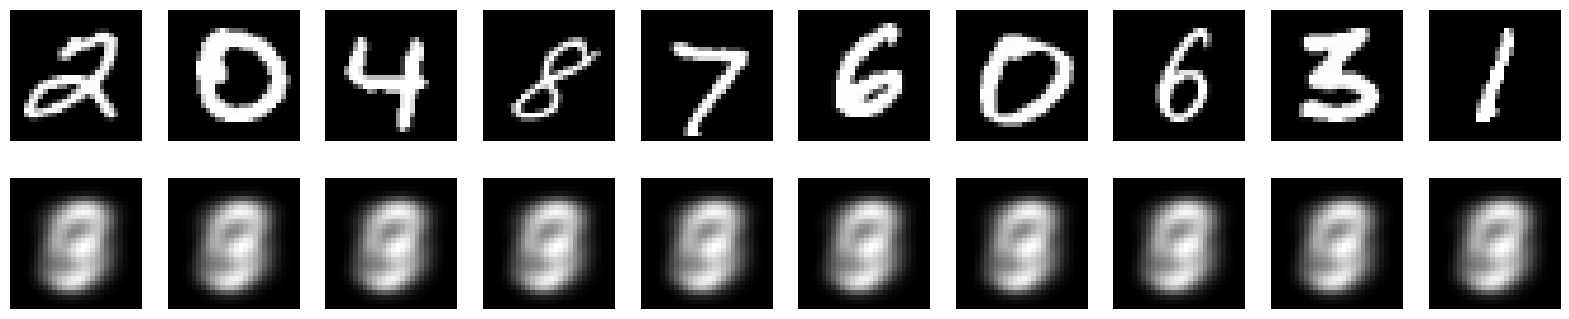

Reconstructions for beta=0.5


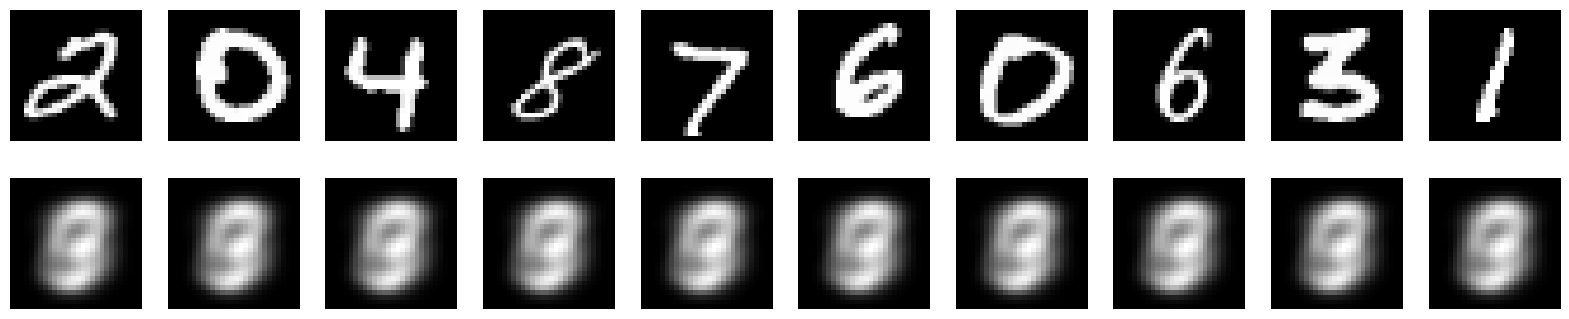

Reconstructions for beta=1


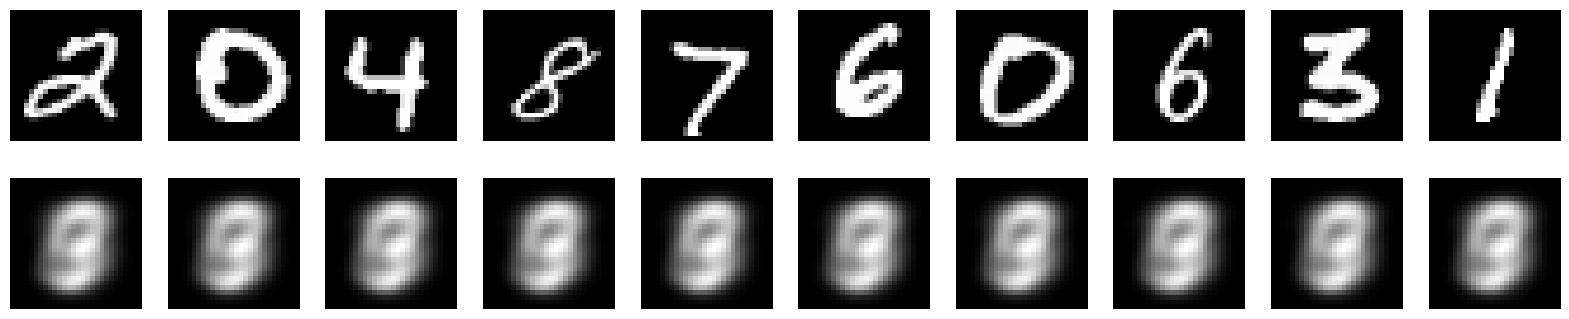

Reconstructions for beta=2


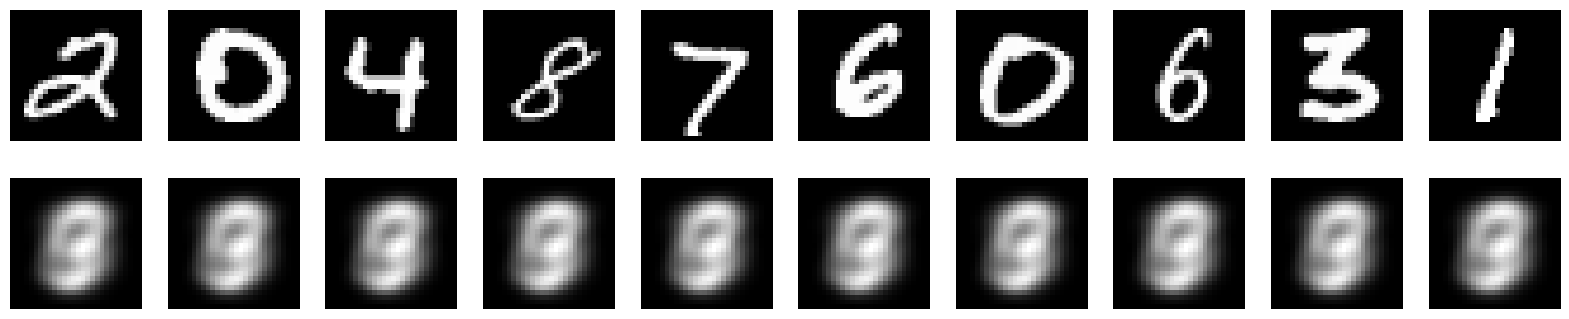

Reconstructions for beta=5


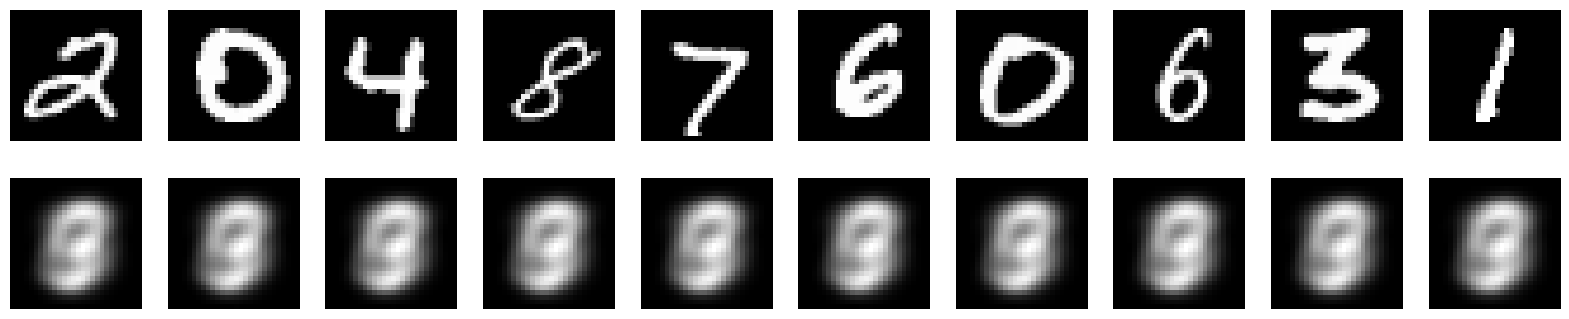

Reconstructions for beta=10


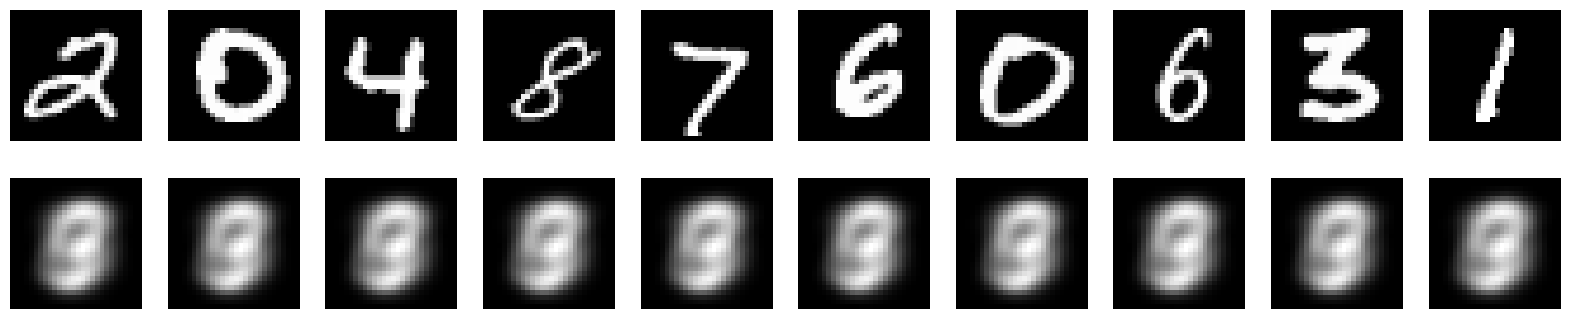

In [22]:
# Function to plot reconstructed and original images
def plot_reconstructions(model, n=10):
    for test_x, _ in ds_test.take(1):
        test_x = tf.reshape(test_x, [-1, original_dim])  # Ensuring the input is flat
        reconstructed, _, _ = model(test_x)
        fig, axes = plt.subplots(2, n, figsize=(20, 4))
        for i in range(n):
            axes[0, i].imshow(tf.reshape(test_x[i], (28, 28)), cmap='gray')  # Correct shape and cmap
            axes[0, i].axis('off')
            axes[1, i].imshow(tf.reshape(reconstructed[i], (28, 28)), cmap='gray')  # Correct shape and cmap
            axes[1, i].axis('off')
        plt.show()

# Plot reconstructions for different beta values
for beta, model in models.items():
    print(f"Reconstructions for beta={beta}")
    plot_reconstructions(model)


Generated samples for beta=0.1


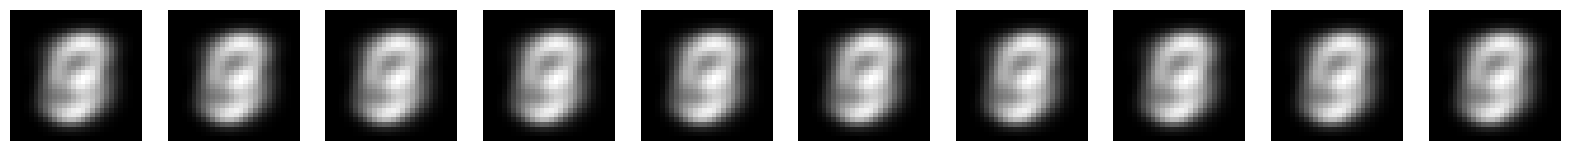

Generated samples for beta=0.5


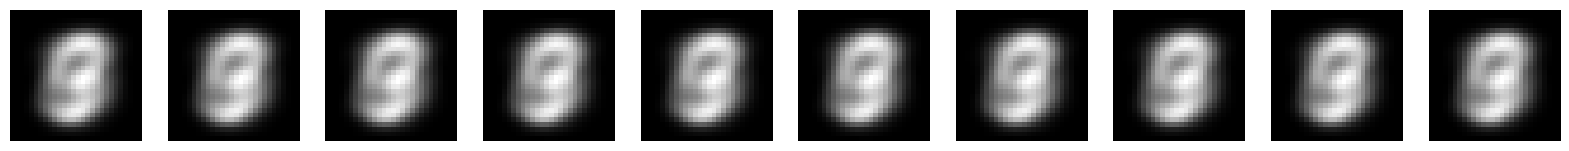

Generated samples for beta=1


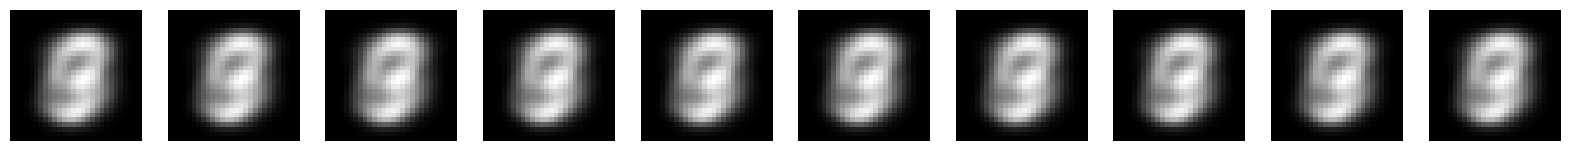

Generated samples for beta=2


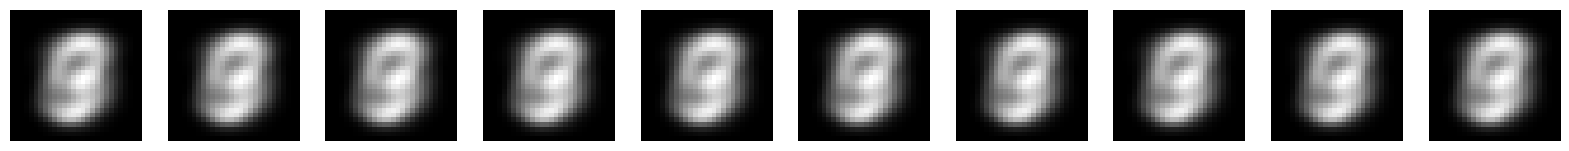

Generated samples for beta=5


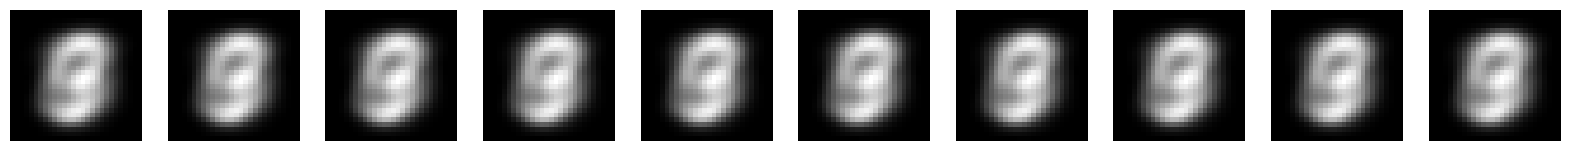

Generated samples for beta=10


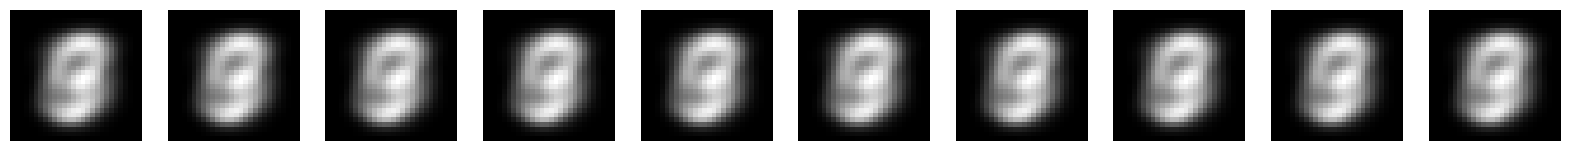

In [23]:
# Generate and plot samples from the latent space
def plot_samples(model, n=10):
    z = tf.random.normal(shape=(n, latent_dim))
    generated_images = model.decoder(z)
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i in range(n):
        axes[i].imshow(tf.reshape(generated_images[i], (28, 28)), cmap='gray')  # Correct shape and cmap
        axes[i].axis('off')
    plt.show()

for beta, model in models.items():
    print(f"Generated samples for beta={beta}")
    plot_samples(model)

Latent space interpolation for beta=0.1


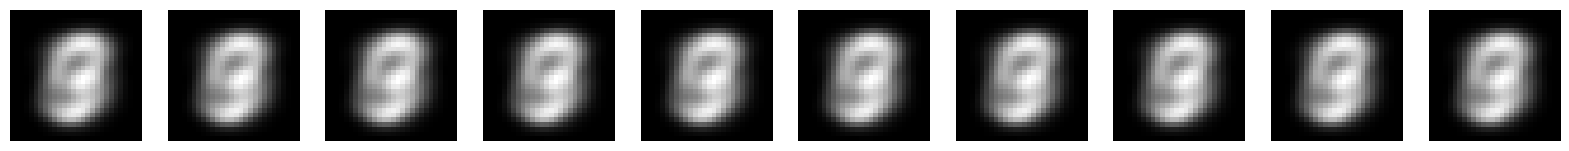

Latent space interpolation for beta=0.5


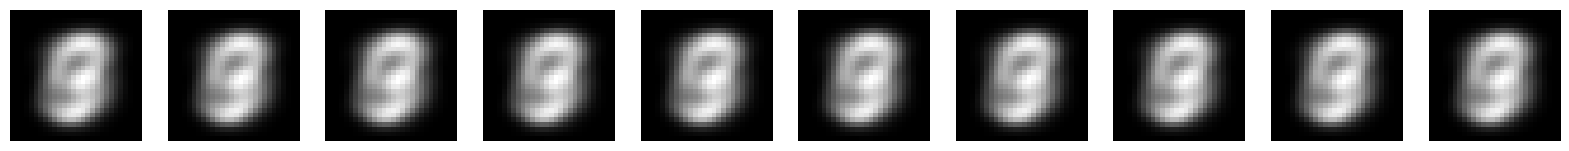

Latent space interpolation for beta=1


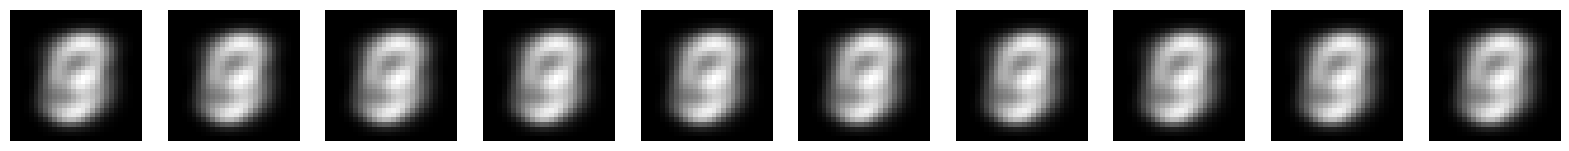

Latent space interpolation for beta=2


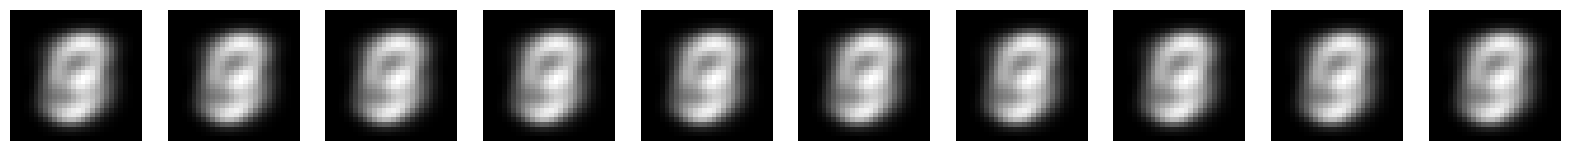

Latent space interpolation for beta=5


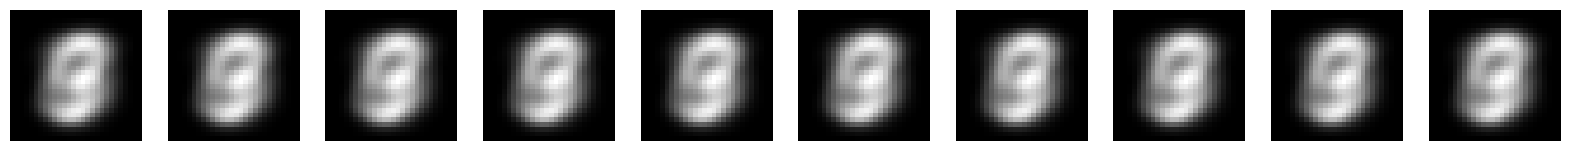

Latent space interpolation for beta=10


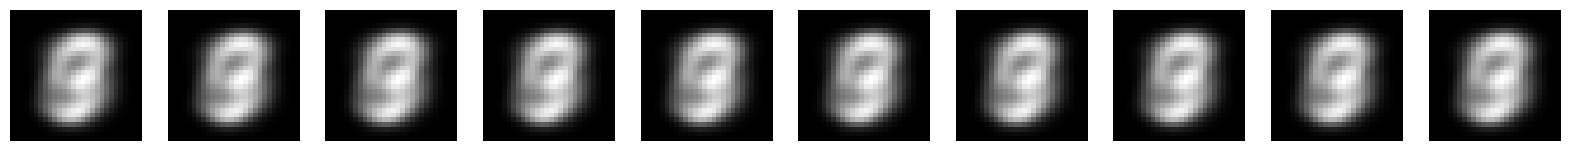

In [24]:
# Latent space manipulation: Interpolation
def interpolate_between_inputs(model, input1, input2, num_steps=10):
    mean1, log_var1 = model.encoder(input1)
    mean2, log_var2 = model.encoder(input2)
    z1 = model.sampling((mean1, log_var1))
    z2 = model.sampling((mean2, log_var2))
    interpolated_z = [z1 + (i / (num_steps - 1)) * (z2 - z1) for i in range(num_steps)]
    interpolated_images = [model.decoder(z) for z in interpolated_z]
    fig, axes = plt.subplots(1, num_steps, figsize=(20, 4))
    for i in range(num_steps):
        axes[i].imshow(tf.reshape(interpolated_images[i], (28, 28)), cmap='gray')  # Correct shape and cmap
        axes[i].axis('off')
    plt.show()

for test_x, _ in ds_test.take(1):
    test_x = tf.reshape(test_x, [-1, original_dim])
    input1 = tf.expand_dims(test_x[0], axis=0)
    input2 = tf.expand_dims(test_x[1], axis=0)
    for beta, model in models.items():
        print(f"Latent space interpolation for beta={beta}")
        interpolate_between_inputs(model, input1, input2)


# Convolutional Variational Autoencoder

#### Source: https://www.tensorflow.org/tutorials/generative/cvae

## Setup

In [25]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-sl3rzf4o
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-sl3rzf4o
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=6afb1fdf64cecfb9d468f7b61bc30867b4d90d75d1db9549589042bac72e6298
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxmqyh5g/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [26]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [27]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [28]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [29]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [30]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian.
Output log-variance instead of the variance directly for numerical stability.

### Decoder network
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [31]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [32]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [33]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [34]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [35]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -157.029296875, time elapse for current epoch: 6.104035377502441


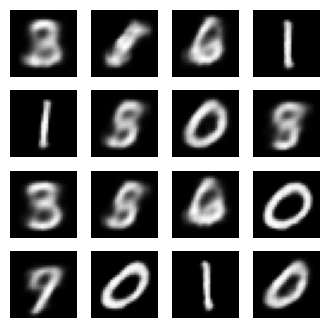

In [36]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [37]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

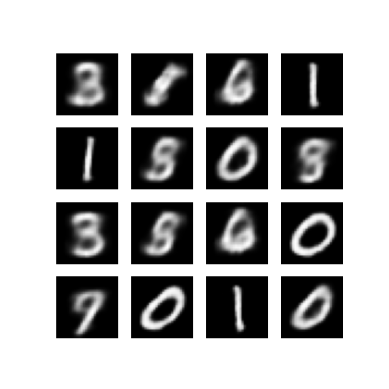

In [38]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [39]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-39-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-39-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



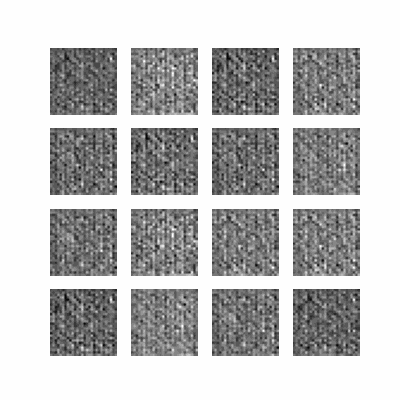

In [40]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [41]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

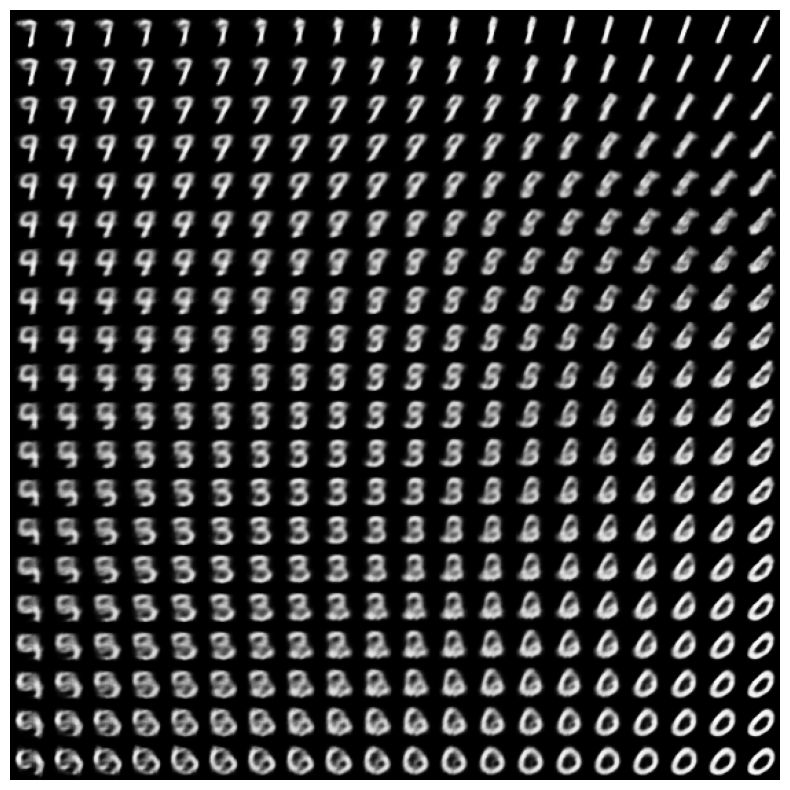

In [42]:
plot_latent_images(model, 20)

#### Trying Beta-VAE using https://www.tensorflow.org/tutorials/generative/cvae

Epoch: 10, Test set ELBO: -151.72848510742188, time elapse for current epoch: 6.526333808898926


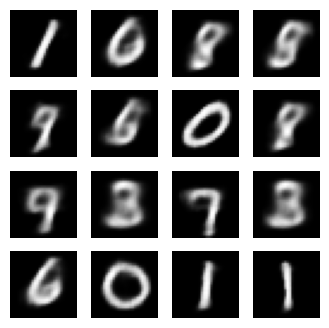

Training Beta-VAE with beta=0.5


StagingError: in user code:

    File "<ipython-input-46-7a96813f63a9>", line 108, in train_step  *
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 225, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable conv2d_14/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [46]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time
from IPython import display
import imageio
import PIL
import glob
import tensorflow_datasets as tfds

# Load the MNIST dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x, beta):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + beta * (logpz - logqz_x))

@tf.function
def train_step(model, x, optimizer, beta):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, beta)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Initialize model and optimizer outside the training function
latent_dim = 2
optimizer = tf.keras.optimizers.Adam(1e-4)
num_examples_to_generate = 16

def train_beta_vae(beta, epochs=10):
    model = CVAE(latent_dim)

    for test_batch in test_dataset.take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_step(model, train_x, optimizer, beta)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x, beta))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
              .format(epoch, elbo, end_time - start_time))
        generate_and_save_images(model, epoch, test_sample)

    return model

# Testing different beta values
betas = [0.1, 0.5, 1, 2, 5, 10]
models = {}
epochs = 10

for beta in betas:
    print(f"Training Beta-VAE with beta={beta}")
    models[beta] = train_beta_vae(beta, epochs)

# Function to manipulate latent dimensions
def manipulate_latent_space(model, image, dim, values):
    mean, logvar = model.encode(image)
    z = model.reparameterize(mean, logvar)
    fig, axes = plt.subplots(1, len(values), figsize=(15, 3))
    for i, value in enumerate(values):
        z[:, dim] = value
        generated_image = model.decode(z, apply_sigmoid=True)
        axes[i].imshow(generated_image[0, :, :, 0], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Encode an image and change a single latent dimension
for test_batch in test_dataset.take(1):
    test_image = test_batch[0:1, :, :, :]
    break

manipulate_latent_space(models[1], test_image, dim=0, values=[-3, -2, -1, 0, 1, 2, 3])

# Plot latent space
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

plot_latent_images(models[1], 20)
